<a href="https://colab.research.google.com/github/lazy-wolf/Sample/blob/main/Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Assignment 4**

```
# Authoured by: Wasim Dawood Shaik
# UNB ID: 3744476
# Date: 4-12-2023
```

**Import Libraries**

In [8]:
import tensorflow as tf
from keras.layers import Input, Dense, Reshape, Lambda
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools

**Importing Dataset**

In [12]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [13]:
x_train, y_train = x_train[:10000], y_train[:10000]

In [14]:
x_test, y_test = x_train[:2000], y_train[:2000]

**Dataset Info**

[cifar10 datset link](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/cifar10/load_data)

*https://www.tensorflow.org/api_docs/python/tf/keras/datasets/cifar10/load_data*

In [15]:
x_train.shape

(10000, 32, 32, 3)

In [16]:
x_test.shape

(2000, 32, 32, 3)

**Data Preprocessing**

In [17]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

**Auto-Encoder (AE) Implementation**

**Auto-Encoder Model Architecture**

In [18]:
#Input Layer
input_img = Input(shape=(32, 32, 3))
#Encoding Layer
x = Reshape((32*32*3,))(input_img)
x = Dense(3000, activation='relu')(x)
x = Dense(1500, activation='relu')(x)
x = Dense(750, activation='relu')(x)
encoded = Dense(350, activation='relu')(x)
#Decoding Layer
x = Dense(750, activation='relu')(encoded)
x = Dense(1500, activation='relu')(x)
x = Dense(3000, activation='relu')(x)
x = Dense(32*32*3, activation='sigmoid')(x)
decoded = Reshape((32, 32, 3))(x)
#AutoEncoder Model
autoencoder = Model(input_img, decoded)

**Compiling the Auto-Encoder**

In [19]:
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002), loss='mse')
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 reshape (Reshape)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 3000)              9219000   
                                                                 
 dense_1 (Dense)             (None, 1500)              4501500   
                                                                 
 dense_2 (Dense)             (None, 750)               1125750   
                                                                 
 dense_3 (Dense)             (None, 350)               262850    
                                                                 
 dense_4 (Dense)             (None, 750)               263250

**Auto-Encoder Training**

In [20]:
#Training the AutoEncoder Model
history = autoencoder.fit(x_train, x_train, validation_data=(x_test, x_test), epochs=50, batch_size=32)

Epoch 1/50
313/313 [==============================] - 12s 12ms/step - loss: 0.0525 - val_loss: 0.0379
Epoch 2/50
313/313 [==============================] - 4s 14ms/step - loss: 0.0374 - val_loss: 0.0369
Epoch 3/50
313/313 [==============================] - 4s 12ms/step - loss: 0.0372 - val_loss: 0.0373
Epoch 4/50
313/313 [==============================] - 4s 11ms/step - loss: 0.0371 - val_loss: 0.0368
Epoch 5/50
313/313 [==============================] - 4s 12ms/step - loss: 0.0366 - val_loss: 0.0334
Epoch 6/50
313/313 [==============================] - 4s 13ms/step - loss: 0.0329 - val_loss: 0.0327
Epoch 7/50
313/313 [==============================] - 4s 13ms/step - loss: 0.0328 - val_loss: 0.0322
Epoch 8/50
313/313 [==============================] - 4s 12ms/step - loss: 0.0311 - val_loss: 0.0304
Epoch 9/50
313/313 [==============================] - 4s 11ms/step - loss: 0.0306 - val_loss: 0.0303
Epoch 10/50
313/313 [==============================] - 4s 12ms/step - loss: 0.0304 - val_l

In [21]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

**Plot Training History**


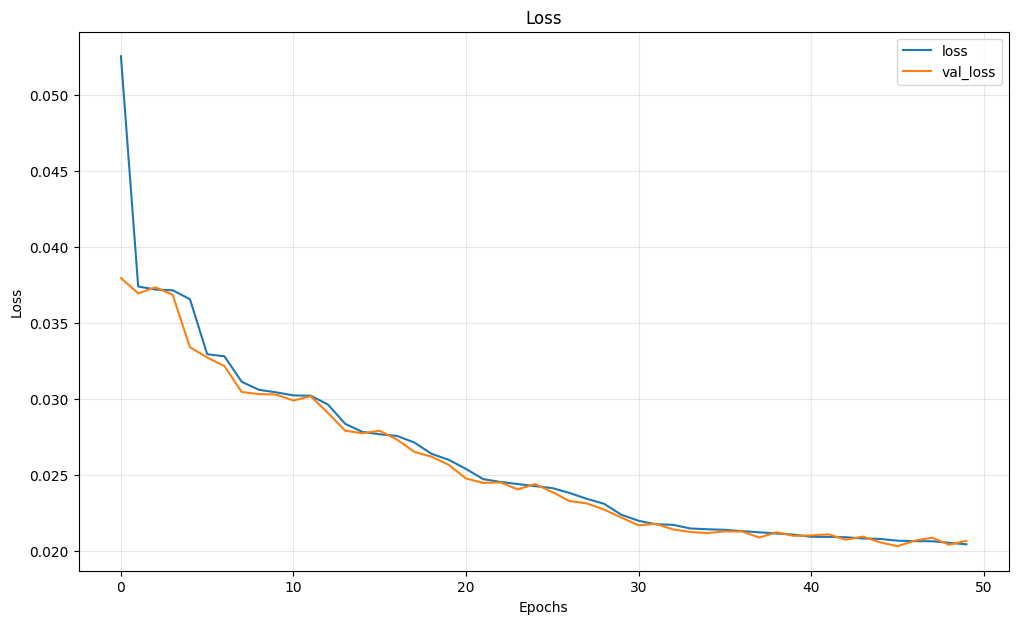

In [22]:
plt.figure(figsize=(12,7))

plt.plot(history.epoch, history.history['loss'], label="loss")
plt.plot(history.epoch, history.history['val_loss'], label="val_loss")

plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(alpha=0.3)
plt.legend()

plt.show()

**Auto-Encoder Evaluation**

In [23]:
results=autoencoder.evaluate(x_test, x_test)
print("Test Loss MSE : ", results)

63/63 [==============================] - 0s 4ms/step - loss: 0.0206
Test Loss MSE :  0.02064933069050312


**Auto Encoder Test Dataset Reconstruction**

In [24]:
x_test_pred = autoencoder.predict(x_test)

63/63 [==============================] - 0s 3ms/step


In [25]:
def calculate_reconstruction_losses(original, reconstructed):
    mse_loss = tf.keras.losses.mean_squared_error(original.flatten(), reconstructed.flatten()).numpy()
    bce_loss = tf.keras.losses.binary_crossentropy(original.flatten(), reconstructed.flatten()).numpy()
    return mse_loss, bce_loss

In [26]:
calculate_reconstruction_losses(x_test, x_test_pred)

(0.02064933, 0.6001253)

**Reconstruction Quality : Auto-Encoder**

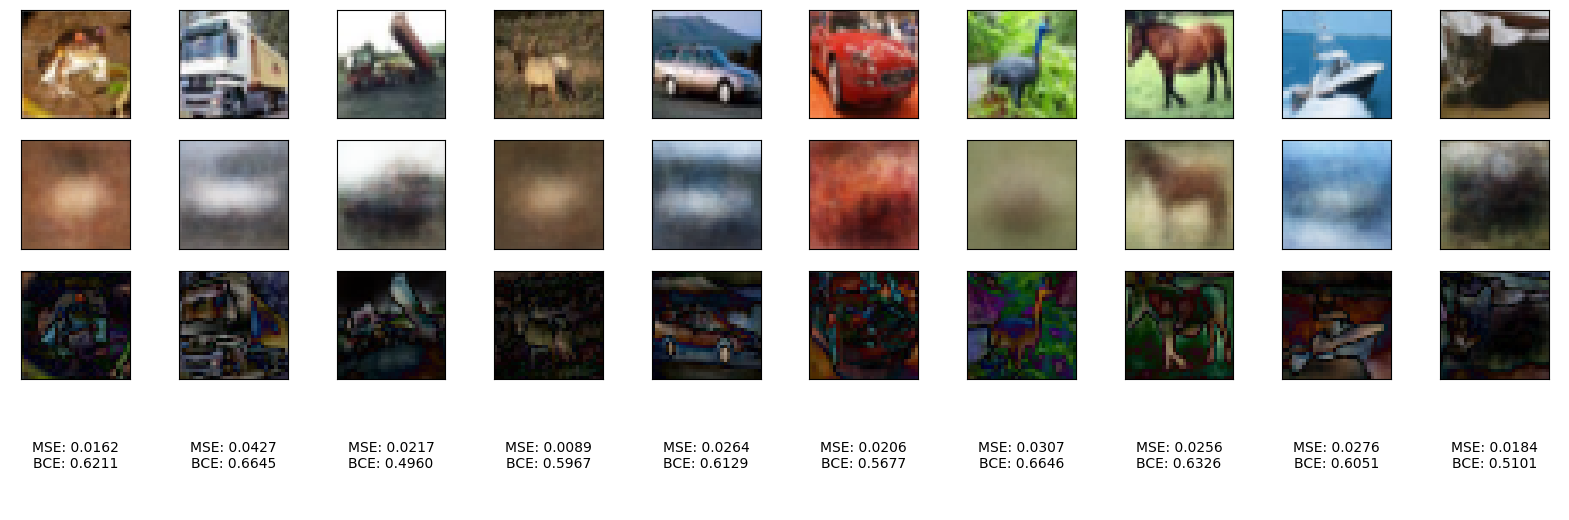

In [27]:
n = 10  # How many image rows, we will display
plt.figure(figsize=(20, 6 + 0.5))  # Adjust the figure size to accommodate three rows
for i in range(n):
    # Display original
    ax = plt.subplot(4, n, i + 1)
    original_img = x_test[i]
    plt.imshow(original_img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(4, n, i + 1 + n)
    reconstructed_img = x_test_pred[i]
    plt.imshow(reconstructed_img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display difference
    ax = plt.subplot(4, n, i + 1 + n * 2)
    difference = np.abs(original_img - reconstructed_img)
    plt.imshow(difference)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Calculate losses
    mse_loss, bce_loss = calculate_reconstruction_losses(original_img, reconstructed_img)

    # Add captions with losses
    ax = plt.subplot(4, n, i + 1 + n * 3)
    plt.axis('off')
    loss_caption = f"MSE: {mse_loss:.4f}\nBCE: {bce_loss:.4f}"
    plt.text(0.5, 0.5, loss_caption, ha='center', va='center', fontsize=10, transform=ax.transAxes)

plt.show()

**Hyperparameter Tuning**



```
# Hyperparameters Choosed : Additional Layer, Learning Rate, Encoding Dimension/ Latent Space Dimension
```



In [28]:
def hyperparameter_tuning_strategy(cofig, x_train, x_test):
  additional_layer, learning_rate, encoding_dim = config
  possible_combinations = list(itertools.product(additional_layer, learning_rate, encoding_dim))
  print("*"*25)
  print(f"Possible No.of Combinations : {possible_combinations}")
  print("*"*25)
  hist = []
  for i in range(len(possible_combinations)):
    print("*"*25)
    print(f"Combination : {i+1}")
    print("*"*25)
    additional_layer, learning_rate, encoding_dim = possible_combinations[i]
    #Input Layer
    input_img = Input(shape=(32, 32, 3))
    #Encoding Layer
    x = Reshape((32*32*3,))(input_img)
    x = Dense(3000, activation='relu')(x)
    if additional_layer:
      x = Dense(1500, activation='relu')(x)
    x = Dense(750, activation='relu')(x)
    encoded = Dense(encoding_dim, activation='relu')(x)
    #Decoding Layer
    x = Dense(750, activation='relu')(encoded)
    if additional_layer:
      x = Dense(1500, activation='relu')(x)
    x = Dense(3000, activation='relu')(x)
    x = Dense(32*32*3, activation='sigmoid')(x)
    decoded = Reshape((32, 32, 3))(x)
    #AutoEncoder Model
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')
    #Training the AutoEncoder Model
    autoencoder.fit(x_train, x_train, validation_data=(x_test, x_test), epochs=50, batch_size=32)
    test_loss = autoencoder.evaluate(x_test, x_test)
    hist.append(list((additional_layer, learning_rate, encoding_dim, test_loss)))
    print(f"Combination : {i+1} -> {possible_combinations[i]} test_mse : {test_loss}")
    print("*"*25)
    print("*"*25)
  return hist


**Different HyperParameter Cofigurations for Tuning**

In [34]:
config = [[True, False], [0.001, 0.002], [175, 350]]

hist = hyperparameter_tuning_strategy(config, x_train, x_test)

*************************
Possible No.of Combinations : [(True, 0.001, 175), (True, 0.001, 350), (True, 0.002, 175), (True, 0.002, 350), (False, 0.001, 175), (False, 0.001, 350), (False, 0.002, 175), (False, 0.002, 350)]
*************************
*************************
Combination : 1
*************************
Epoch 1/50
313/313 [==============================] - 6s 12ms/step - loss: 0.0455 - val_loss: 0.0374
Epoch 2/50
313/313 [==============================] - 5s 15ms/step - loss: 0.0350 - val_loss: 0.0332
Epoch 3/50
313/313 [==============================] - 5s 15ms/step - loss: 0.0330 - val_loss: 0.0329
Epoch 4/50
313/313 [==============================] - 4s 14ms/step - loss: 0.0316 - val_loss: 0.0307
Epoch 5/50
313/313 [==============================] - 5s 16ms/step - loss: 0.0306 - val_loss: 0.0306
Epoch 6/50
313/313 [==============================] - 4s 13ms/step - loss: 0.0300 - val_loss: 0.0285
Epoch 7/50
313/313 [==============================] - 4s 13ms/step - loss: 0.02

**Different HyperParameter Value's Test Losses Comparison**

In [35]:
hist_hp_comb = pd.DataFrame(hist, columns=["Additional Layer", "Learning Rate", "Encoding Dimesnionality/Latent Sapce Dimensionality","Test Loss"])
hist_hp_comb = hist_hp_comb.sort_values(by=["Test Loss"], ascending=True)
hist_hp_comb

,Additional Layer,Learning Rate,Encoding Dimesnionality/Latent Sapce Dimensionality,Test Loss
5,False,0.001,350,0.007040
4,False,0.001,175,0.009461
1,True,0.001,350,0.011630
7,False,0.002,350,0.014282
0,True,0.001,175,0.015435
3,True,0.002,350,0.021212
2,True,0.002,175,0.023588
6,False,0.002,175,0.025276


**Reconstruction Quality Changes After HyperParameter Tuning**

In [39]:
print("*"*25)
print(f"----Best Combination---- \n Additional Layer = {hist_hp_comb.iloc[0,0]}\n Learning Rate = {hist_hp_comb.iloc[0,1]}\n Encoding Dimesnionality/Latent Sapce Dimensionality = {hist_hp_comb.iloc[0,2]}\n")
print("*"*25)
print("*"*25)
before_mse = np.round(results, 4)
after_mse = np.round(hist_hp_comb.iloc[0, 3], 4)
print(f'Results Before Tunning:\n Test Loss MSE: {before_mse}\n')
print(f'Results After Tunning:\n Test Loss MSE: {after_mse}\n')
print(f'{np.round((before_mse-after_mse)*100/before_mse)}% Reconstruction Quality Improvement')

*************************
----Best Combination---- 
 Additional Layer = False
 Learning Rate = 0.001
 Encoding Dimesnionality/Latent Sapce Dimensionality = 350

*************************
*************************
Results Before Tunning:
 Test Loss MSE: 0.0206

Results After Tunning:
 Test Loss MSE: 0.007

66.0% Reconstruction Quality Improvement


**Best AutoEncoder Model after Tuning**

In [41]:
additional_layer, learning_rate, encoding_dim = list(hist_hp_comb.iloc[0, :3])

**Best Auto-Encoder Architecture**

In [42]:
#Input Layer
input_img = Input(shape=(32, 32, 3))
#Encoding Layer
x = Reshape((32*32*3,))(input_img)
x = Dense(3000, activation='relu')(x)
if additional_layer:
  x = Dense(1500, activation='relu')(x)
x = Dense(750, activation='relu')(x)
encoded = Dense(encoding_dim, activation='relu')(x)
#Decoding Layer
x = Dense(750, activation='relu')(encoded)
if additional_layer:
  x = Dense(1500, activation='relu')(x)
x = Dense(3000, activation='relu')(x)
x = Dense(32*32*3, activation='sigmoid')(x)
decoded = Reshape((32, 32, 3))(x)

**Compiling the Best Auto-Encoder**

In [43]:
#AutoEncoder Model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')
autoencoder.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 reshape_34 (Reshape)        (None, 3072)              0         
                                                                 
 dense_120 (Dense)           (None, 3000)              9219000   
                                                                 
 dense_121 (Dense)           (None, 750)               2250750   
                                                                 
 dense_122 (Dense)           (None, 350)               262850    
                                                                 
 dense_123 (Dense)           (None, 750)               263250    
                                                                 
 dense_124 (Dense)           (None, 3000)              225

**Best Autoencoder - Encoder Model**

In [44]:
# Define the encoder model
encoder_best = Model(input_img, encoded)

**Best Auto-Encoder Training**

In [45]:
#Training the AutoEncoder Model
history = autoencoder.fit(x_train, x_train, validation_data=(x_test, x_test), epochs=50, batch_size=32)


Epoch 1/50
313/313 [==============================] - 5s 11ms/step - loss: 0.0392 - val_loss: 0.0308
Epoch 2/50
313/313 [==============================] - 3s 10ms/step - loss: 0.0267 - val_loss: 0.0245
Epoch 3/50
313/313 [==============================] - 3s 10ms/step - loss: 0.0239 - val_loss: 0.0235
Epoch 4/50
313/313 [==============================] - 3s 10ms/step - loss: 0.0226 - val_loss: 0.0221
Epoch 5/50
313/313 [==============================] - 3s 10ms/step - loss: 0.0218 - val_loss: 0.0209
Epoch 6/50
313/313 [==============================] - 3s 10ms/step - loss: 0.0205 - val_loss: 0.0196
Epoch 7/50
313/313 [==============================] - 3s 11ms/step - loss: 0.0189 - val_loss: 0.0184
Epoch 8/50
313/313 [==============================] - 3s 10ms/step - loss: 0.0183 - val_loss: 0.0182
Epoch 9/50
313/313 [==============================] - 3s 10ms/step - loss: 0.0177 - val_loss: 0.0176
Epoch 10/50
313/313 [==============================] - 3s 10ms/step - loss: 0.0169 - val_lo

**Plot Training History**

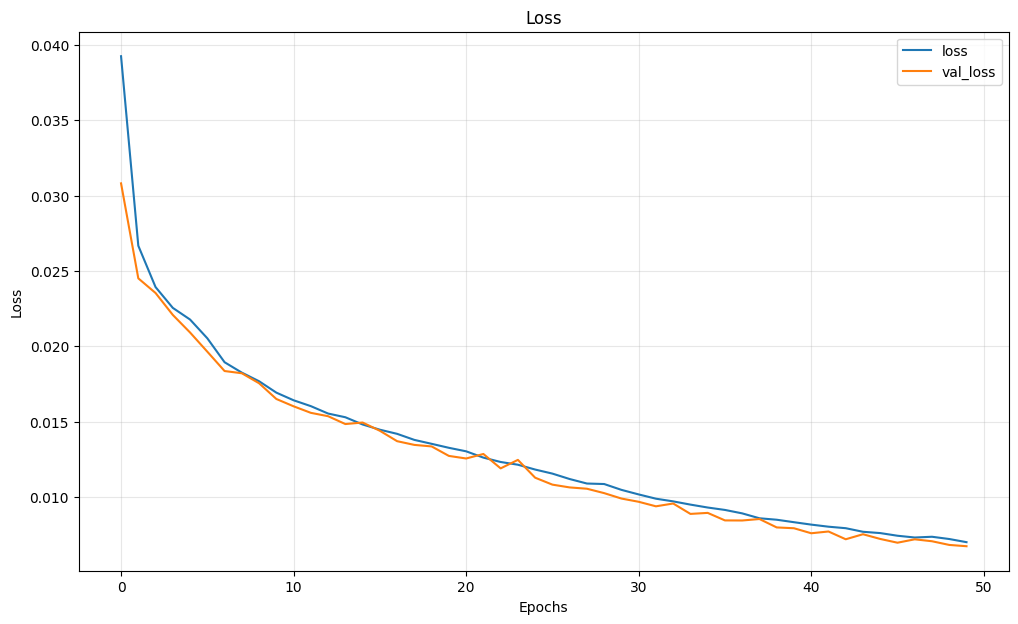

In [46]:
plt.figure(figsize=(12,7))

plt.plot(history.epoch, history.history['loss'], label="loss")
plt.plot(history.epoch, history.history['val_loss'], label="val_loss")

plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(alpha=0.3)
plt.legend()

plt.show()

**Best Auto-Encoder Evaluation**

In [48]:
test_loss = autoencoder.evaluate(x_test, x_test)
print("Test Loss MSE : ", test_loss)

63/63 [==============================] - 0s 6ms/step - loss: 0.0068
Test Loss MSE :  0.006753407418727875


**Best Auto Encoder Test Dataset Reconstruction**

In [49]:
x_test_pred = autoencoder.predict(x_test)
mse_loss, bce_loss = calculate_reconstruction_losses(x_test, x_test_pred)
(mse_loss, bce_loss)

63/63 [==============================] - 0s 3ms/step


(0.0067534093, 0.5669226)

**Reconstruction Quality : Best Auto-Encoder**

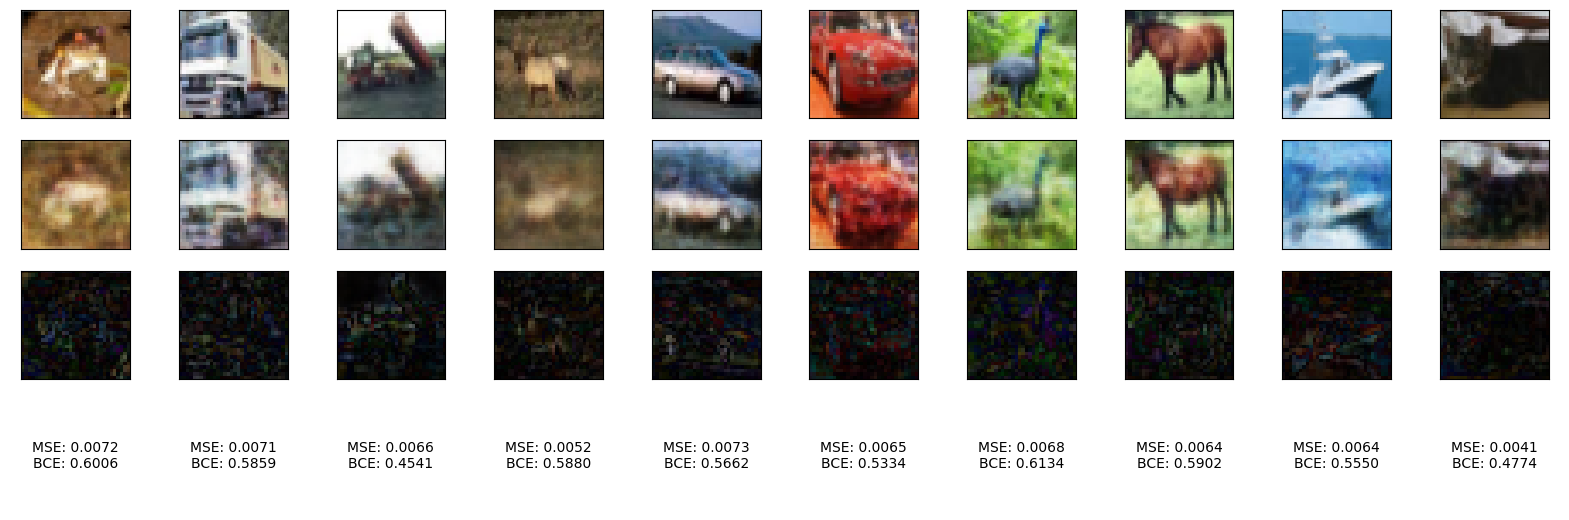

In [50]:
n = 10  # # How many image rows, we will display
plt.figure(figsize=(20, 6 + 0.5))  # Adjust the figure size to accommodate three rows
for i in range(n):
    # Display original
    ax = plt.subplot(4, n, i + 1)
    original_img = x_test[i]
    plt.imshow(original_img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(4, n, i + 1 + n)
    reconstructed_img = x_test_pred[i]
    plt.imshow(reconstructed_img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display difference
    ax = plt.subplot(4, n, i + 1 + n * 2)
    difference = np.abs(original_img - reconstructed_img)
    plt.imshow(difference)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Calculate losses
    mse_loss, bce_loss = calculate_reconstruction_losses(original_img, reconstructed_img)

    # Add captions with losses
    ax = plt.subplot(4, n, i + 1 + n * 3)
    plt.axis('off')
    loss_caption = f"MSE: {mse_loss:.4f}\nBCE: {bce_loss:.4f}"
    plt.text(0.5, 0.5, loss_caption, ha='center', va='center', fontsize=10, transform=ax.transAxes)

plt.show()

**Variational Auto-Encoder (VAE) Implementation**

**Variational Auto-Encoder Model Architecture**

In [151]:
# Hyperparameters
batch_size = 32
original_dim = 3072  # 32*32*3
latent_dim = 2
intermediate_dim = 128
epochs = 50
epsilon_std = 1.0

# Encoder network
x = Input(shape=(original_dim,), name='input')
h = Dense(intermediate_dim, activation='relu', name='encoding')(x)
z_mean = Dense(latent_dim, name='mean')(h)
z_log_var = Dense(latent_dim, name='log-variance')(h)

# Sampling function
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# Sample from the latent distribution
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Decoder network
decoder_h = Dense(intermediate_dim, activation='relu', name='decoder_h')
decoder_mean = Dense(original_dim, activation='sigmoid', name='decoder_mean')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# VAE model
vae = Model(x, x_decoded_mean)

# Loss function: reconstruction loss + KL divergence
reconstruction_loss = binary_crossentropy(x, x_decoded_mean) * original_dim
kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer=Adam(learning_rate=0.002))

In [152]:
x_train.shape

(10000, 32, 32, 3)

In [153]:
x_train_vae = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_vae = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

**Variational Auto-Encoder Model Training**

In [154]:
#Training the AutoEncoder Model
history = vae.fit(x_train_vae, x_train_vae, epochs=epochs, batch_size=batch_size, validation_data=(x_test_vae, x_test_vae))

Epoch 1/50
313/313 [==============================] - 3s 5ms/step - loss: 2013.0107 - val_loss: 1982.1870
Epoch 2/50
313/313 [==============================] - 2s 6ms/step - loss: 1962.7324 - val_loss: 1966.8748
Epoch 3/50
313/313 [==============================] - 2s 7ms/step - loss: 1959.7245 - val_loss: 1964.7319
Epoch 4/50
313/313 [==============================] - 2s 5ms/step - loss: 1958.6907 - val_loss: 1964.7240
Epoch 5/50
313/313 [==============================] - 2s 5ms/step - loss: 1958.0935 - val_loss: 1963.0388
Epoch 6/50
313/313 [==============================] - 2s 5ms/step - loss: 1957.6099 - val_loss: 1965.6505
Epoch 7/50
313/313 [==============================] - 1s 5ms/step - loss: 1956.5345 - val_loss: 1963.0972
Epoch 8/50
313/313 [==============================] - 2s 5ms/step - loss: 1956.1444 - val_loss: 1962.7971
Epoch 9/50
313/313 [==============================] - 1s 5ms/step - loss: 1955.6554 - val_loss: 1962.8535
Epoch 10/50
313/313 [=========================

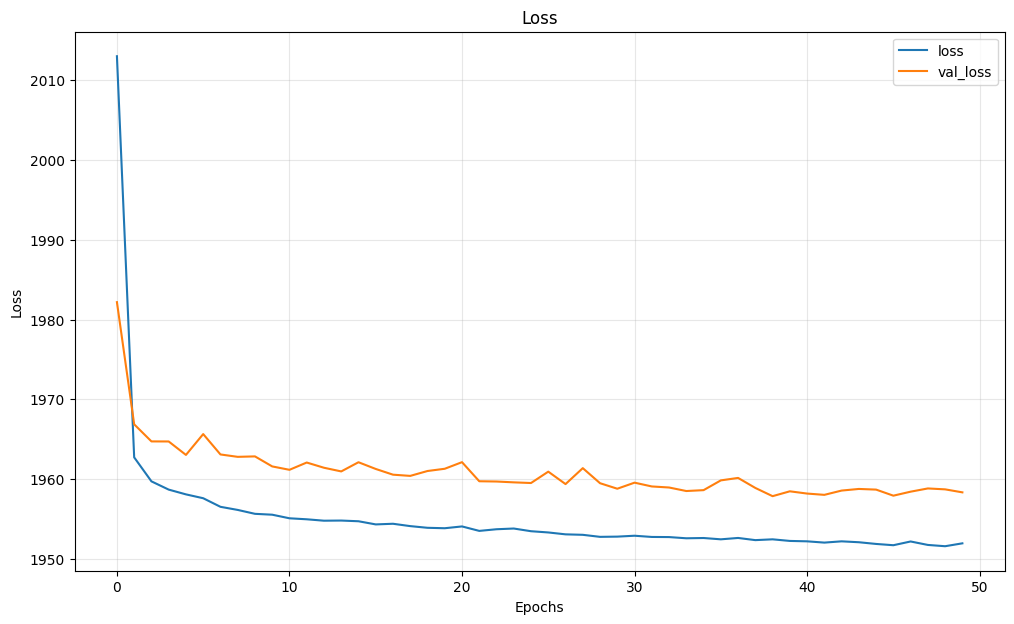

In [159]:
plt.figure(figsize=(12,7))

plt.plot(history.epoch, history.history['loss'], label="loss")
plt.plot(history.epoch, history.history['val_loss'], label="val_loss")

plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(alpha=0.3)
plt.legend()

plt.show()

In [155]:
results = vae.evaluate(x_test_vae, x_test_vae)
print("Test Loss VAE : ", results)

63/63 [==============================] - 0s 3ms/step - loss: 1958.3256
Test Loss VAE :  1958.3255615234375


In [156]:
x_test_pred = vae.predict(x_test_vae)

63/63 [==============================] - 0s 3ms/step


In [157]:
mse_loss, bce_loss = calculate_reconstruction_losses(x_test_vae, x_test_pred)
(mse_loss, bce_loss)

(0.036592476, 0.6357465)

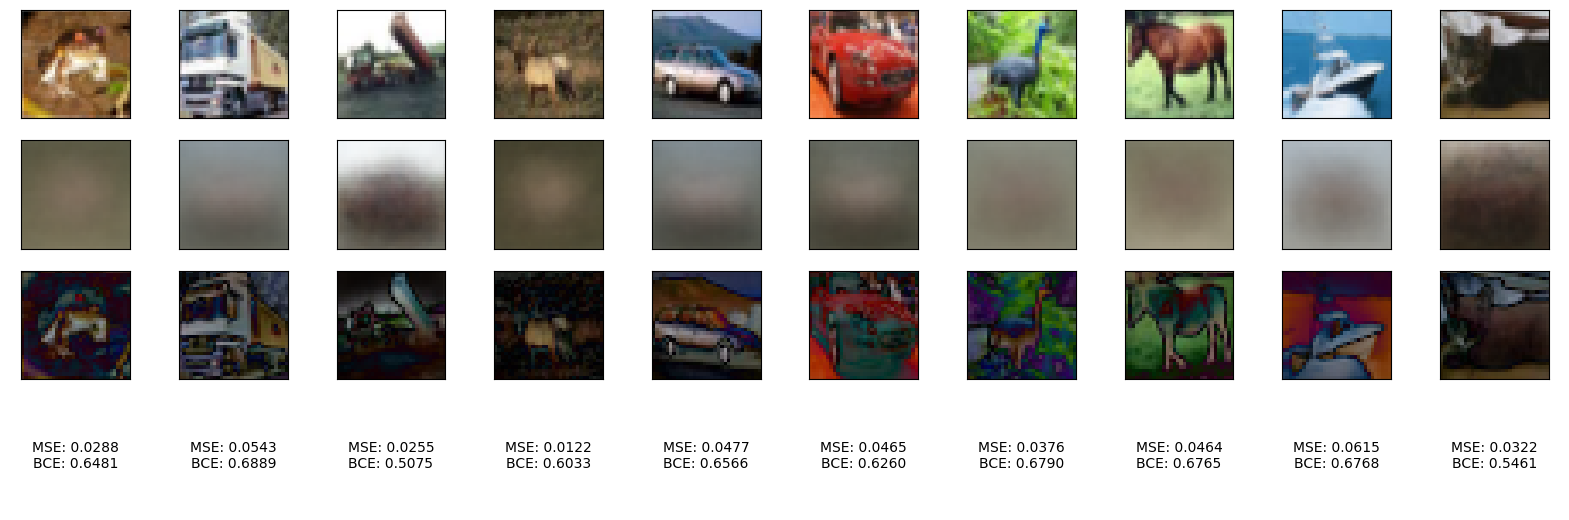

In [158]:
n = 10  # # How many image rows, we will display
plt.figure(figsize=(20, 6 + 0.5))  # Adjust the figure size to accommodate three rows
for i in range(n):
    # Display original
    ax = plt.subplot(4, n, i + 1)
    original_img = x_test_vae[i].reshape(32,32,3)
    plt.imshow(original_img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(4, n, i + 1 + n)
    reconstructed_img = x_test_pred[i].reshape(32,32,3)
    plt.imshow(reconstructed_img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display difference
    ax = plt.subplot(4, n, i + 1 + n * 2)
    difference = np.abs(original_img - reconstructed_img)
    plt.imshow(difference)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Calculate losses
    mse_loss, bce_loss = calculate_reconstruction_losses(original_img, reconstructed_img)

    # Add captions with losses
    ax = plt.subplot(4, n, i + 1 + n * 3)
    plt.axis('off')
    loss_caption = f"MSE: {mse_loss:.4f}\nBCE: {bce_loss:.4f}"
    plt.text(0.5, 0.5, loss_caption, ha='center', va='center', fontsize=10, transform=ax.transAxes)

plt.show()

In [165]:
def hyperparameter_tuning_strategy(cofig, x_train, x_test):
  intermediate_dim, latent_dim, learning_rate = config
  possible_combinations = list(itertools.product(intermediate_dim, latent_dim, learning_rate))
  print("*"*25)
  print(f"Possible No.of Combinations : {possible_combinations}")
  print("*"*25)
  hist = []
  for i in range(len(possible_combinations)):
    print("*"*25)
    print(f"Combination : {i+1}")
    print("*"*25)
    intermediate_dim, latent_dim, learning_rate = possible_combinations[i]
    # Hyperparameters
    batch_size = 32
    original_dim = 3072  # 32*32*3
    epochs = 50
    epsilon_std = 1.0

    # Encoder network
    x = Input(shape=(original_dim,), name='input')
    h = Dense(intermediate_dim, activation='relu', name='encoding')(x)
    z_mean = Dense(latent_dim, name='mean')(h)
    z_log_var = Dense(latent_dim, name='log-variance')(h)

    # Sampling function
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
        return z_mean + K.exp(z_log_var / 2) * epsilon

    # Sample from the latent distribution
    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    # Decoder network
    decoder_h = Dense(intermediate_dim, activation='relu', name='decoder_h')
    decoder_mean = Dense(original_dim, activation='sigmoid', name='decoder_mean')
    h_decoded = decoder_h(z)
    x_decoded_mean = decoder_mean(h_decoded)

    # VAE model
    vae = Model(x, x_decoded_mean)

    # Loss function: reconstruction loss + KL divergence
    reconstruction_loss = binary_crossentropy(x, x_decoded_mean) * original_dim
    kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)
    vae.compile(optimizer=Adam(learning_rate=learning_rate))
    #Training the AutoEncoder Model
    x_train_vae = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
    x_test_vae = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
    history = vae.fit(x_train_vae, x_train_vae, shuffle=True, epochs=epochs, batch_size=batch_size, validation_data=(x_test_vae, x_test_vae))
    test_loss = vae.evaluate(x_test_vae, x_test_vae)
    hist.append(list((intermediate_dim, latent_dim, learning_rate, test_loss)))
    print(f"Combination : {i+1} -> {possible_combinations[i]}  test_mse : {test_loss}")
    print("*"*25)
    print("*"*25)
  return hist

In [ ]:
config = [[128, 256, 512], [2, 4, 8], [0.001, 0.0015, 0.002]]

hist = hyperparameter_tuning_strategy(config, x_train, x_test)

*************************
Possible No.of Combinations : [(128, 2, 0.001), (128, 2, 0.0015), (128, 2, 0.002), (128, 4, 0.001), (128, 4, 0.0015), (128, 4, 0.002), (128, 8, 0.001), (128, 8, 0.0015), (128, 8, 0.002), (256, 2, 0.001), (256, 2, 0.0015), (256, 2, 0.002), (256, 4, 0.001), (256, 4, 0.0015), (256, 4, 0.002), (256, 8, 0.001), (256, 8, 0.0015), (256, 8, 0.002), (512, 2, 0.001), (512, 2, 0.0015), (512, 2, 0.002), (512, 4, 0.001), (512, 4, 0.0015), (512, 4, 0.002), (512, 8, 0.001), (512, 8, 0.0015), (512, 8, 0.002)]
*************************
*************************
Combination : 1
*************************
Epoch 1/50
313/313 [==============================] - 28s 83ms/step - loss: 2040.6090 - val_loss: 2015.6169
Epoch 2/50
313/313 [==============================] - 2s 5ms/step - loss: 1980.5138 - val_loss: 1969.8049
Epoch 3/50
313/313 [==============================] - 2s 5ms/step - loss: 1963.3621 - val_loss: 1966.2236
Epoch 4/50
313/313 [==============================] - 2s 5ms/

In [39]:
hist_hp_comb = pd.DataFrame(hist, columns=["Intermediate Dimension", "Latent Dimension Space", "Test Loss VAE"])
hist_hp_comb = hist_hp_comb.sort_values(by=["Test Loss VAE"], ascending=True)
hist_hp_comb

,Intermediate Dimension,Latent Dimension Space,Test Loss VAE
3,256,4,1912.582642
1,128,4,1913.097900
2,256,2,1953.536499
0,128,2,1958.352295


In [40]:
print("*"*25)
print(f"----Best Combination---- \n Learning Rate = {hist.iloc[0,0]}\n Latent Dimension Space = {hist.iloc[0,1]}\n")
print("*"*25)
print("*"*25)
before_mse = np.round(results, 4)
after_mse = np.round(hist.iloc[0, 2], 4)
print(f'Results Before Tunning:\n Test Loss MSE: {before_mse}\n')
print(f'Results After Tunning:\n Test Loss MSE: {after_mse}\n')
print(f'{np.round((before_mse-after_mse)*100/before_mse)}% Reconstruction Quality Improvement')

*************************
----Best Combination---- 
 Learning Rate = 256
 Latent Dimension Space = 4

*************************
*************************
Results Before Tunning:
 Test Loss MSE: 1959.1708

Results After Tunning:
 Test Loss MSE: 1912.5826

2.0% Improvement


In [41]:
list(hist.iloc[0, :2])

[256.0, 4.0]

In [42]:
intermediate_dim, latent_dim = list(hist.iloc[0, :2])

In [43]:
# Hyperparameters
batch_size = 32
original_dim = 3072  # 32*32*3
latent_dim = int(latent_dim)
intermediate_dim = int(intermediate_dim)
epochs = 25
epsilon_std = 1.0

# Encoder network
x = Input(shape=(original_dim,), name='input')
h = Dense(intermediate_dim, activation='relu', name='encoding')(x)
z_mean = Dense(latent_dim, name='mean')(h)
z_log_var = Dense(latent_dim, name='log-variance')(h)

# Sampling function
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# Sample from the latent distribution
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Decoder network
decoder_h = Dense(intermediate_dim, activation='relu', name='decoder_h')
decoder_mean = Dense(original_dim, activation='sigmoid', name='decoder_mean')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# VAE model
vae = Model(x, x_decoded_mean)

# Loss function: reconstruction loss + KL divergence
reconstruction_loss = binary_crossentropy(x, x_decoded_mean) * original_dim
kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer=Adam())
# vae.summary()

In [ ]:
#Early Stopping with Patience as 5
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
file_path = 'best_model.h5'
#Saving Best Model
model_check = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)
#Training the AutoEncoder Model
x_train_vae = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_vae = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
history = vae.fit(x_train_vae, x_train_vae, shuffle=True, epochs=epochs, batch_size=batch_size, validation_data=(x_test_vae, x_test_vae), callbacks=[early_stop, model_check], verbose=0)

In [ ]:
plt.figure(figsize=(12,7))

plt.plot(history.epoch, history.history['loss'], label="loss")
plt.plot(history.epoch, history.history['val_loss'], label="val_loss")

plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(alpha=0.3)
plt.legend()

plt.show()

In [ ]:
test_loss = vae.evaluate(x_test_vae, x_test_vae)

In [ ]:
x_test_pred = vae.predict(x_test_vae)

In [ ]:
mse_loss, bce_loss = calculate_reconstruction_losses(x_test_vae, x_test_pred)

In [ ]:
n = 10  # How many image rows, we will display
plt.figure(figsize=(20, 6 + 0.5))  # Adjust the figure size to accommodate three rows
for i in range(n):
    # Display original
    ax = plt.subplot(4, n, i + 1)
    original_img = x_test_vae[i].reshape(32,32,3)
    plt.imshow(original_img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(4, n, i + 1 + n)
    reconstructed_img = x_test_pred[i].reshape(32,32,3)
    plt.imshow(reconstructed_img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display difference
    ax = plt.subplot(4, n, i + 1 + n * 2)
    difference = np.abs(original_img - reconstructed_img)
    plt.imshow(difference)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Calculate losses
    mse_loss, bce_loss = calculate_reconstruction_losses(original_img, reconstructed_img)

    # Add captions with losses
    ax = plt.subplot(4, n, i + 1 + n * 3)
    plt.axis('off')
    loss_caption = f"MSE: {mse_loss:.4f}\nBCE: {bce_loss:.4f}"
    plt.text(0.5, 0.5, loss_caption, ha='center', va='center', fontsize=10, transform=ax.transAxes)

plt.show()

In [ ]:
# Build a model to project inputs on the latent space
encoder = Model(x, z_mean)

In [ ]:
# Display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test_vae, batch_size=batch_size)
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()